## Duffing oscillator

In [137]:
# Imports
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import equinox as eqx
jax.config.update('jax_enable_x64',True)
from evaluation_metrics import get_nrmse
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

We consider the IVP

$$
u'' = \underbrace{- \alpha u - \beta u^3 -\delta u'}_{\mathcal{P}(u)} + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0 
$$

where $\alpha = -3$, $\beta = 3$, $\delta = 0.2$, $\gamma = 1$ and $\omega = 2$.


Equivalently, if we introduce the variables $x_0 = u$, and $x_1 = u'$ we can re-write the IVP as a system of two first-order ODEs

$$
\frac{d \mathbf{x}}{dt} =
\frac{d}{dt}
\begin{bmatrix}
x_0 \\
x_1
\end{bmatrix} =  
\begin{bmatrix}
x_1 \\
-\alpha x_0 - \beta x_0^3 - \delta x_1 + \gamma \cos(\omega t)
\end{bmatrix}\qquad x_0(0) = 0, x_1(0) = 0
$$


In [138]:
# Define the constants
alpha = -3.
beta = 3.
delta = 0.2
gamma = 1.
omega = 2

# Define forcing term
def forcing(t):
    return gamma*jnp.cos(omega*t)

# Define the Duffing RHS
@eqx.filter_jit
def duffing(t,x, args):
    return jnp.array([
        x[1],
        - alpha * x[0] - beta * x[0]**3 - delta * x[1] + forcing(t)
    ])

In [139]:
def show_term(c,neg = False):
    if neg is True:
        c = -c
    if c>0:
        return f"+{c}"
    elif c<0:
        return f"-{jnp.abs(c)}"
    else:
        return "0"
print(f"x''(t) = u(t) {show_term(beta,neg = True)} x(t)^3 {show_term(alpha,neg = True)} x(t) {show_term(delta,neg = True)} x'(t) \n u(t) = {gamma} cos({omega}t)")
print(f"")

x''(t) = u(t) -3.0 x(t)^3 +3.0 x(t) -0.2 x'(t) 
 u(t) = 1.0 cos(2t)



We use ```diffrax``` to solve numerically the ODE system

In [140]:
# Initial time
t0 = 0.
# Final time
t1 = 50.
# Define the RHS of the system
term = ODETerm(duffing)
# Pick a solver
solver = Dopri5()
# Save dense output, that can later be evaluated at any point inside [t0,t1]
saveat = SaveAt(dense=True)
# Size control: Adapts the step size to produce a solution accurate to a given tolerance
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)
# Initial condition
y0 = jnp.zeros(2)
# Solve
ode_sol = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 5000
    )

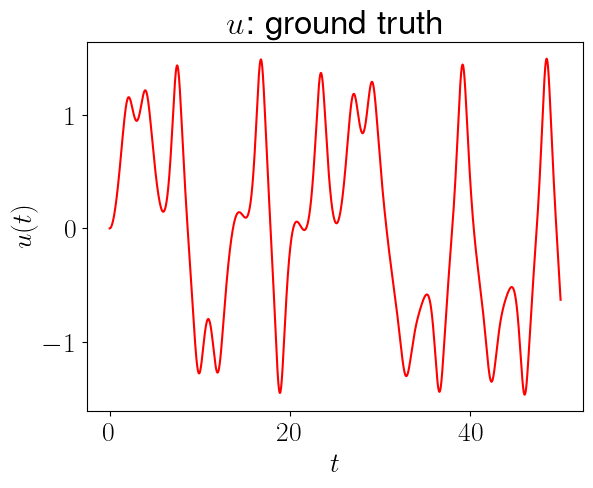

In [141]:
# Fine grid
tvals = jnp.linspace(t0,t1,5000)
# Fine grid values
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.title('$u$: ground truth')
plt.plot(tvals,y_full[:,0], c = 'red')
plt.xlabel('$t$')
plt.ylabel('$u(t)$')
# plt.plot(tvals,y_full[:,1],label = "u'(t)")
plt.show()

# Get the data for the problem

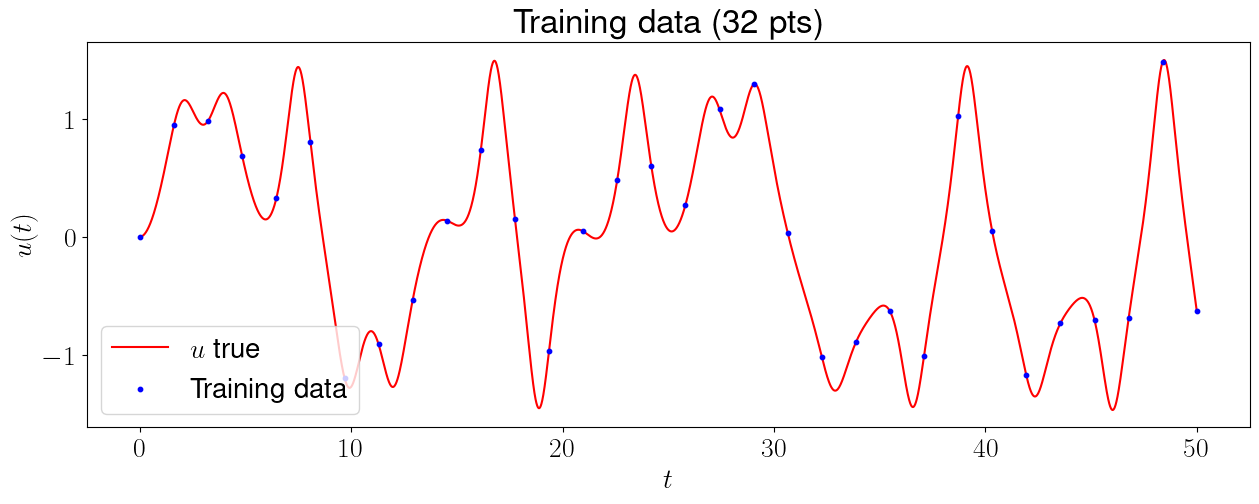

In [142]:
plt.figure(figsize=(15,5))
# Fine grid
tvals = jnp.linspace(t0,t1,5000)
# u(Fine grid)
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.plot(tvals,y_full[:,0], c = 'red', zorder=0, label = '$u$ true')
# X_obs
num_obs = 32 
obs_times = jnp.linspace(t0,t1,num_obs)
# obs_times = jnp.hstack([jnp.linspace(0.,20,num_obs),jnp.linspace(30.,50,num_obs)])
# obs_times = jnp.linspace(t0,40,num_obs)
# u(X_obs)
u_obs = jax.vmap(ode_sol.evaluate)(obs_times)[:,0]
plt.scatter(obs_times,u_obs, s=10,c= 'blue', zorder=1, label = 'Training data')
plt.title(f'Training data ({num_obs} pts)')
plt.ylabel('$u(t)$')
plt.xlabel('$t$')
plt.legend(loc = 'lower left')
plt.show()

In [143]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,jacrev
import numpy as np
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *

In [144]:
t_obs = obs_times.reshape(-1,1)

## Train the 1 step and 2 step method

In [145]:
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params,
    get_gaussianRBF,
    get_rq_kernel
)
from EquationModel import CholInducedRKHS, OperatorPDEModel,InducedOperatorModel
from functools import partial
from Kernels import log1pexp,inv_log1pexp

def dtt_k(k,index = 0):
    return dt_k(dt_k(k,index),index)

u_operators = (eval_k,dt_k,dtt_k)

feature_operators = (eval_k,dt_k)

k_u = get_rq_kernel(1.)
num_colloc = 1000
t_grid = jnp.linspace(t0,t1,num_colloc).reshape(-1,1)


u_model = CholInducedRKHS(
    t_grid,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(t_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,t_grid,u_params_init))
    .reshape(
            len(t_grid),
            len(feature_operators),
            order = 'F'
        )
)
grid_features_init = jnp.hstack([t_grid,grid_features_init])

num_P_inducing = 500
P_inducing_points = jax.random.choice(jax.random.PRNGKey(13),grid_features_init,(num_P_inducing,))

k_P_u_part = get_gaussianRBF(1.)
def k_P(x,y):
    return k_P_u_part(x[1:],y[1:])
P_model = InducedOperatorModel(P_inducing_points,k_P)

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (t_obs,),
    (u_obs,),
    (t_grid,),
    feature_operators,
    rhs_operator=dtt_k,
    datafit_weight = 50,
    rhs_forcing_values = (-forcing(t_grid)[:,0],),
    num_P_operator_params = 500
)

utt_init = EqnModel.apply_rhs_op_single(u_model,u_params_init,EqnModel.collocation_points[0])-forcing(t_grid)[:,0]
P_params_init = P_model.get_fitted_params(grid_features_init,utt_init,lam = 1e-3)
params_init = jnp.hstack([u_params_init,P_params_init])

In [146]:
from Optimizers import CholeskyLM,LMParams

In [147]:
optParams = LMParams(max_iter = 1001,min_alpha = 1e-9)
sol,conv = CholeskyLM(params_init,EqnModel,1e-9,optParams = optParams)

  0%|          | 4/1001 [00:12<38:03,  2.29s/it]  

Iteration 0, loss = 0.1688, gradnorm = 0.2539, alpha = 2.5, improvement_ratio = 1.001
Iteration 1, loss = 0.1566, gradnorm = 0.2002, alpha = 2.083, improvement_ratio = 1.002
Iteration 2, loss = 0.1455, gradnorm = 0.1686, alpha = 1.736, improvement_ratio = 1.003
Iteration 3, loss = 0.1349, gradnorm = 0.1483, alpha = 1.447, improvement_ratio = 1.004
Iteration 4, loss = 0.1248, gradnorm = 0.1324, alpha = 1.206, improvement_ratio = 1.004
Iteration 5, loss = 0.1154, gradnorm = 0.1178, alpha = 1.005, improvement_ratio = 1.005


  5%|▌         | 55/1001 [00:13<00:35, 26.32it/s]

Iteration 50, loss = 0.03446, gradnorm = 0.004081, alpha = 0.0002747, improvement_ratio = 1.073


 11%|█         | 106/1001 [00:15<00:30, 29.78it/s]

Iteration 100, loss = 0.008561, gradnorm = 0.002031, alpha = 0.002724, improvement_ratio = 0.2374


 15%|█▌        | 154/1001 [00:17<00:28, 30.08it/s]

Iteration 150, loss = 0.00842, gradnorm = 0.0006583, alpha = 0.002517, improvement_ratio = 0.371


 21%|██        | 206/1001 [00:18<00:25, 30.77it/s]

Iteration 200, loss = 0.008282, gradnorm = 0.0003969, alpha = 0.002326, improvement_ratio = 0.5382


 25%|██▌       | 254/1001 [00:20<00:24, 30.63it/s]

Iteration 250, loss = 0.008174, gradnorm = 0.0001427, alpha = 0.001296, improvement_ratio = 0.8828


 31%|███       | 306/1001 [00:22<00:22, 31.02it/s]

Iteration 300, loss = 0.008099, gradnorm = 6.917e-05, alpha = 0.0003342, improvement_ratio = 0.9892


 35%|███▌      | 354/1001 [00:23<00:20, 31.15it/s]

Iteration 350, loss = 0.00803, gradnorm = 0.0001045, alpha = 8.62e-05, improvement_ratio = 0.989


 40%|████      | 402/1001 [00:25<00:19, 31.23it/s]

Iteration 400, loss = 0.007945, gradnorm = 0.0006414, alpha = 3.201e-05, improvement_ratio = 0.7781


 45%|████▌     | 454/1001 [00:26<00:18, 29.45it/s]

Iteration 450, loss = 0.007883, gradnorm = 0.001556, alpha = 0.001509, improvement_ratio = 0.1899


 51%|█████     | 506/1001 [00:28<00:16, 30.45it/s]

Iteration 500, loss = 0.007835, gradnorm = 0.0002911, alpha = 0.001395, improvement_ratio = 0.5781


 55%|█████▌    | 554/1001 [00:30<00:14, 30.93it/s]

Iteration 550, loss = 0.007791, gradnorm = 7.29e-05, alpha = 0.0005968, improvement_ratio = 0.9675


 61%|██████    | 606/1001 [00:31<00:12, 31.05it/s]

Iteration 600, loss = 0.007746, gradnorm = 7.462e-05, alpha = 0.0001069, improvement_ratio = 0.9881


 65%|██████▌   | 654/1001 [00:33<00:12, 28.11it/s]

Iteration 650, loss = 0.007683, gradnorm = 0.0008105, alpha = 2.757e-05, improvement_ratio = 0.5948


 71%|███████   | 706/1001 [00:35<00:10, 29.35it/s]

Iteration 700, loss = 0.007631, gradnorm = 0.001695, alpha = 0.0008665, improvement_ratio = 0.1482


 75%|███████▌  | 754/1001 [00:36<00:08, 30.50it/s]

Iteration 750, loss = 0.007595, gradnorm = 0.0002768, alpha = 0.001107, improvement_ratio = 0.5633


 81%|████████  | 806/1001 [00:38<00:06, 30.82it/s]

Iteration 800, loss = 0.007552, gradnorm = 5.444e-05, alpha = 0.0004934, improvement_ratio = 0.9717


 85%|████████▌ | 854/1001 [00:40<00:04, 30.92it/s]

Iteration 850, loss = 0.007506, gradnorm = 5.227e-05, alpha = 0.0001832, improvement_ratio = 0.9886


 91%|█████████ | 906/1001 [00:41<00:03, 31.03it/s]

Iteration 900, loss = 0.00746, gradnorm = 6.833e-05, alpha = 5.671e-05, improvement_ratio = 0.9872


 95%|█████████▌| 954/1001 [00:43<00:01, 31.13it/s]

Iteration 950, loss = 0.007407, gradnorm = 0.0002917, alpha = 1.755e-05, improvement_ratio = 0.9085


100%|██████████| 1001/1001 [00:45<00:00, 22.21it/s]


Iteration 1000, loss = 0.007348, gradnorm = 0.001332, alpha = 1.126e-05, improvement_ratio = 0.2939


In [148]:
tvals

Array([0.00000000e+00, 1.00020004e-02, 2.00040008e-02, ...,
       4.99799960e+01, 4.99899980e+01, 5.00000000e+01], dtype=float64)

In [149]:
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

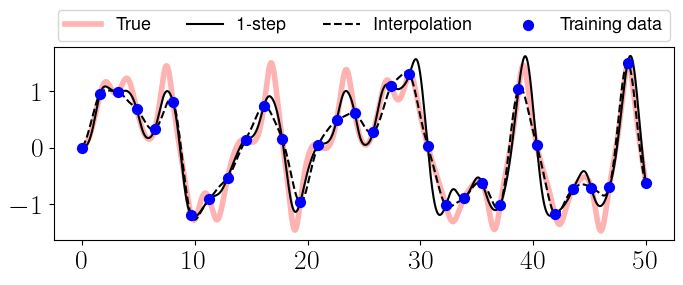

In [150]:
# u predictions
plt.figure(figsize=(8,2.5))
# u true
true = y_full[:,0]
plt.plot(tvals,true,label = 'True', c = 'red', lw = 4, alpha= 0.3, zorder=0)
# 1 step u pred
pred1 = u_model.point_evaluate(tvals,EqnModel.get_u_params(sol)[0])
err_1 = jnp.linalg.norm(true - pred1) / jnp.linalg.norm(true)
plt.plot(tvals,pred1,c = 'black',ls ='solid',label = r'1-step', zorder=1)
# 2 step u predv
pred2 = u_model.point_evaluate(tvals,u_params_init)
err_2 = jnp.linalg.norm(true - pred2) / jnp.linalg.norm(true)
plt.plot(tvals,pred2,label = r'Interpolation',ls = 'dashed', c= 'black', zorder=2)
# Training data
plt.scatter(obs_times,u_obs, s=50, zorder=3, c="blue", label='Training data')
# Plot configs
# plt.title(f'$u$ predictions of 1 step (err: {round(err_1,3)}) and Interpolation (err: {round(err_2,4)}) methods')
# plt.xlabel('$t$')
# plt.ylabel('$u$')
# plt.legend(fontsize = 14, loc = 'lower left')
# plt.tight_layout()
plt.legend(fontsize = 13, loc = 'upper center', ncol = 4, bbox_to_anchor=(0.5, 1.24))

plt.savefig('u_filtering_and_data.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )
plt.show()

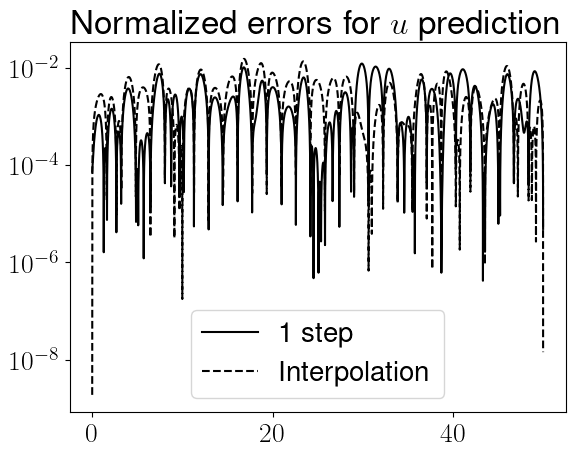

In [151]:
# u errors
# plt.figure(figsize=(15,5))
true = jax.vmap(ode_sol.evaluate)(tvals)[:,0]
# 1 step method
pred_1_step = u_model.point_evaluate(tvals,EqnModel.get_u_params(sol)[0])
plt.plot(tvals,jnp.abs(pred_1_step- true)/jnp.linalg.norm(true),label = '1 step',c = 'black',ls ='solid')
# 2 step method
pred_2_step = u_model.point_evaluate(tvals,u_params_init)
plt.plot(tvals,jnp.abs(pred_2_step- true)/jnp.linalg.norm(true),label = 'Interpolation', c = 'black', ls= 'dashed')
# Plot configs
plt.title('Normalized errors for $u$ prediction')
plt.yscale('log')
plt.legend()
plt.show()

In [152]:
# Filtering error
final = 50.
# Domain
t_values = np.linspace(0,final,5000)
# True
true_values = jax.vmap(ode_sol.evaluate)(t_values)[:,0]
# 1-step
pred_values_1step = u_model.point_evaluate(t_values,EqnModel.get_u_params(sol)[0])
# Interp
pred_values_interp = u_model.point_evaluate(t_values,u_params_init)

# Print errors
print(f'Error 1step in [0,{final}]: ', get_nrmse(true_values, pred_values_1step))
print(f'Error interp in [0,{final}]: ', get_nrmse(true_values, pred_values_interp))

Error 1step in [0,50.0]:  0.2684861409398477
Error interp in [0,50.0]:  0.3246176453681845


## How well perform $\widehat{P}$ learned from 1 step and 2 step methods ?

Let's compute the simulated trajectories starting at a different initial condition from:

1. $u'' = \underbrace{- \alpha u - \beta u^3 -\delta u'}_{\mathcal{P}(u)} + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

2. $u'' = \widehat{P}_{1step}(u) + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

3. $u'' = \widehat{P}_{2step}(u) + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

In [78]:
# Learned parameters for 1-step
fitted_P_params = EqnModel.get_P_params(sol)
# Phat 1-step method
def learned_vf(t,x,args):
    input = jnp.hstack([t,x]).reshape(1,-1)
    return jnp.array([x[1],P_model.predict(input,fitted_P_params)[0] + forcing(t)])
# Phat 2-step method
def init_vf(t,x,args):
    input = jnp.hstack([t,x]).reshape(1,-1)
    return jnp.array([x[1],P_model.predict(input,P_params_init)[0] + forcing(t)])

## Initial condition 1

In [79]:
y0 = jnp.array([0.,0.5]) 

In [80]:
# P
term = ODETerm(duffing)
# Phat from 1 step
fitted_term = ODETerm(learned_vf)
# Phat from 2 step
init_term = ODETerm(init_vf)

# Simulate between
t0,t1 = 0,10 

ode_truth = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_fitted = diffeqsolve(
    terms = fitted_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_init = diffeqsolve(
    terms = init_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

In [81]:
# SINDy
feature_operators_SINDy = (eval_k,dt_k,dtt_k)

S = (u_model.evaluate_operators(feature_operators_SINDy,t_grid,u_params_init).reshape(
            len(t_grid), 
            len(feature_operators_SINDy),
            order = 'F'
                ))
# Constant
CONST = jnp.ones(len(S[:,0]))
# First degree
U = S[:,0]
U_t = S[:,1]
# Second degree
UU = jnp.multiply(S[:,0],S[:,0])
UU_t = jnp.multiply(S[:,0],S[:,1])
U_tU_t = jnp.multiply(S[:,1],S[:,1])
# Third degree
UUU = jnp.multiply(S[:,0],UU)
UUU_t = jnp.multiply(UU,S[:,1])
UU_tU_t = jnp.multiply(S[:,0],U_tU_t)
U_tU_tU_t = jnp.multiply(S[:,1],U_tU_t)

# Forcing values feature
F = forcing(t_grid)

# Build dictionary
Theta = jnp.vstack([CONST, 
                    U,U_t, 
                    UU,UU_t,U_tU_t,
                    UUU,UUU_t,UU_tU_t,U_tU_tU_t,
                    F[:,0]]).T
# LHS: Assume it is u_ddot
U_tt = S[:,2]

# Threshold algorithm
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi
   
# Run SINDY
coeffs_SINDy = sparsifyDynamics(Theta,U_tt.reshape(-1,1),lamb = 1e-2, n = 1)
coeffs_SINDy = jnp.array(coeffs_SINDy[:,0])
print(coeffs_SINDy)

# Phat from SINDy
@eqx.filter_jit
def Phat_SINDy(t,x, args):
    return jnp.array([
        x[1], jnp.dot(coeffs_SINDy, 
                      jnp.array([1.,
                          x[0],
                          x[1],
                          x[0]**2,
                          x[0] * x[1],
                          x[1]**2,
                          x[0]**3,
                          x[0]**2 * x[1],
                          x[0] * x[1]**2,
                          x[1]**3,
                          forcing(t)
                          ]))
    ])

SINDy_term = ODETerm(Phat_SINDy)

ode_SINDy = diffeqsolve(
    terms = SINDy_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

[-0.17330005  0.38582517  0.19643389  0.17186581 -0.07816957  0.18951089
 -0.82803903 -0.13843791 -0.79903234 -0.07280214  0.32515595]


In [82]:
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

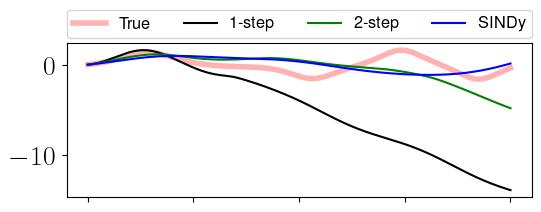

In [83]:
# u predictions
plt.figure(figsize=(6,2))
tvals = jnp.linspace(t0,t1,5000)
# u true
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
plt.plot(tvals, true, label = 'True', c = 'red', lw = 4, alpha= 0.3, zorder=0)
# u pred 1-step
pred1 = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
err_1 = jnp.linalg.norm(true - pred1) / jnp.linalg.norm(true)
plt.plot(tvals,jax.vmap(ode_fitted.evaluate)(tvals)[:,0], c = 'black',ls ='solid',label = r'1-step', zorder=1)
# u pred 2-step
pred2 = jax.vmap(ode_init.evaluate)(tvals)[:,0]
err_2 = jnp.linalg.norm(true - pred2) / jnp.linalg.norm(true)
plt.plot(tvals,pred2,label = r'2-step', c= 'green', zorder=2)
# u pred SINDy
predSINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
err_SINDy = jnp.linalg.norm(true - predSINDy) / jnp.linalg.norm(true)
plt.plot(tvals,predSINDy,label = r'SINDy', c= 'blue', zorder=3)
# Plt configs
# plt.title(f'$u$ predictions of 1 step (err: {round(err_1,3)}), 2 step (err: {round(err_2,3)}) and SINDy (err: {round(err_SINDy,2)}) methods with new ICs')
# plt.xlabel('$t$')
plt.gca().set_xticklabels([])
# plt.ylabel('$u$')
# plt.tight_layout()
plt.legend(fontsize = 11.8, loc = 'upper center', ncol = 4, bbox_to_anchor=(0.5, 1.27))
plt.savefig('u_extrapolating1.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )
plt.show()

In [84]:
# Dictionary to store results
errors_IC1 = {'1-step': [],
 '2-step':[],
 'SINDy':[]}


for final in [3,6,10]:
    # Operator learning errors
    tvals = jnp.linspace(t0,final,5000)
    # u true
    true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]

    # u pred 1-step
    pred1 = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
    err_1 = get_nrmse(true,pred1)
    errors_IC1['1-step'].append(float(err_1))
    print(f'Error 1_step in [0,{final}]: ',err_1)

    # u pred 2-step
    pred2 = jax.vmap(ode_init.evaluate)(tvals)[:,0]
    err_2 = get_nrmse(true,pred2)
    errors_IC1['2-step'].append(float(err_2))
    print(f'Error 2_step in [0,{final}]: ',err_2)

    # u pred SINDy
    predSINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
    err_SINDy = get_nrmse(true,predSINDy)
    errors_IC1['SINDy'].append(float(err_SINDy))
    print(f'Error SINDy in [0,{final}]: ',err_SINDy)

Error 1_step in [0,3]:  0.4880989926151071
Error 2_step in [0,3]:  0.4029572532964768
Error SINDy in [0,3]:  0.6012516658036479
Error 1_step in [0,6]:  2.359192834544107
Error 2_step in [0,6]:  1.1033120624521662
Error SINDy in [0,6]:  1.0878453306385194
Error 1_step in [0,10]:  7.233946034622456
Error 2_step in [0,10]:  1.6064644769063694
Error SINDy in [0,10]:  1.260313073309397


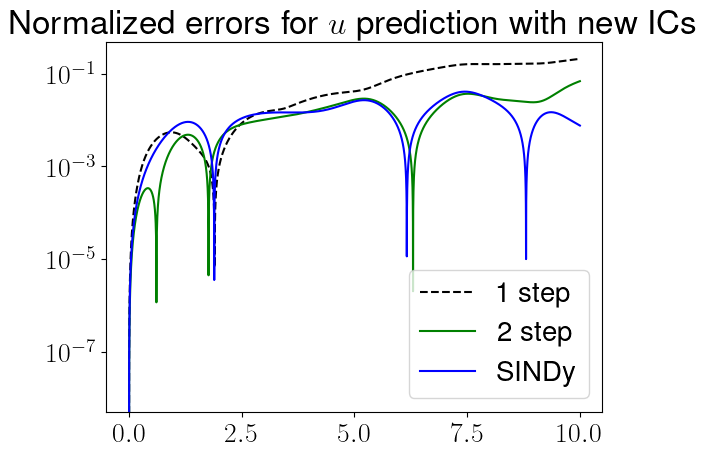

In [85]:
# u errors
# plt.figure(figsize=(15,5))
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
# 1 step method
pred_1_step = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_1_step- true)/jnp.linalg.norm(true),label = '1 step',c = 'black',ls ='dashed')
# 2 step method
pred_2_step = jax.vmap(ode_init.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_2_step- true)/jnp.linalg.norm(true),label = '2 step', c= 'green')
# SINDy method
pred_SINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_SINDy- true)/jnp.linalg.norm(true),label = 'SINDy', c= 'blue')
# Plot configs
plt.title('Normalized errors for $u$ prediction with new ICs')
plt.yscale('log')
plt.legend()
plt.show()

## Initial condition 2

In [86]:
y0 = jnp.array([0.,1]) 

In [87]:
# P
term = ODETerm(duffing)
# Phat from 1 step
fitted_term = ODETerm(learned_vf)
# Phat from 2 step
init_term = ODETerm(init_vf)

# Simulate between
t0,t1 = 0,10 

ode_truth = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_fitted = diffeqsolve(
    terms = fitted_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_init = diffeqsolve(
    terms = init_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

In [88]:
# SINDy
feature_operators_SINDy = (eval_k,dt_k,dtt_k)

S = (u_model.evaluate_operators(feature_operators_SINDy,t_grid,u_params_init).reshape(
            len(t_grid), 
            len(feature_operators_SINDy),
            order = 'F'
                ))
# Constant
CONST = jnp.ones(len(S[:,0]))
# First degree
U = S[:,0]
U_t = S[:,1]
# Second degree
UU = jnp.multiply(S[:,0],S[:,0])
UU_t = jnp.multiply(S[:,0],S[:,1])
U_tU_t = jnp.multiply(S[:,1],S[:,1])
# Third degree
UUU = jnp.multiply(S[:,0],UU)
UUU_t = jnp.multiply(UU,S[:,1])
UU_tU_t = jnp.multiply(S[:,0],U_tU_t)
U_tU_tU_t = jnp.multiply(S[:,1],U_tU_t)

# Forcing values feature
F = forcing(t_grid)

# Build dictionary
Theta = jnp.vstack([CONST, 
                    U,U_t, 
                    UU,UU_t,U_tU_t,
                    UUU,UUU_t,UU_tU_t,U_tU_tU_t,
                    F[:,0]]).T
# LHS: Assume it is u_ddot
U_tt = S[:,2]

# Threshold algorithm
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi
   
# Run SINDY
coeffs_SINDy = sparsifyDynamics(Theta,U_tt.reshape(-1,1),lamb = 1e-2, n = 1)
coeffs_SINDy = jnp.array(coeffs_SINDy[:,0])
print(coeffs_SINDy)

# Phat from SINDy
@eqx.filter_jit
def Phat_SINDy(t,x, args):
    return jnp.array([
        x[1], jnp.dot(coeffs_SINDy, 
                      jnp.array([1.,
                          x[0],
                          x[1],
                          x[0]**2,
                          x[0] * x[1],
                          x[1]**2,
                          x[0]**3,
                          x[0]**2 * x[1],
                          x[0] * x[1]**2,
                          x[1]**3,
                          forcing(t)
                          ]))
    ])

SINDy_term = ODETerm(Phat_SINDy)

ode_SINDy = diffeqsolve(
    terms = SINDy_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

[-0.17330005  0.38582517  0.19643389  0.17186581 -0.07816957  0.18951089
 -0.82803903 -0.13843791 -0.79903234 -0.07280214  0.32515595]


In [89]:
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

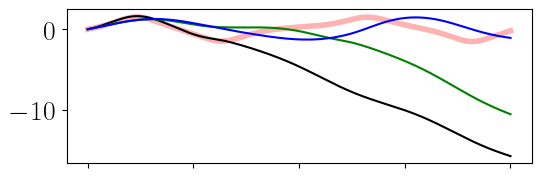

In [90]:
# u predictions
plt.figure(figsize=(6,2))
tvals = jnp.linspace(t0,t1,5000)
# u true
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
plt.plot(tvals, true, label = 'True', c = 'red', lw = 4, alpha= 0.3, zorder=0)
# u pred 1-step
pred1 = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
err_1 = jnp.linalg.norm(true - pred1) / jnp.linalg.norm(true)
plt.plot(tvals,jax.vmap(ode_fitted.evaluate)(tvals)[:,0], c = 'black',ls ='solid',label = r'1-step', zorder=1)
# u pred 2-step
pred2 = jax.vmap(ode_init.evaluate)(tvals)[:,0]
err_2 = jnp.linalg.norm(true - pred2) / jnp.linalg.norm(true)
plt.plot(tvals,pred2,label = r'2-step', c= 'green', zorder=2)
# u pred SINDy
predSINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
err_SINDy = jnp.linalg.norm(true - predSINDy) / jnp.linalg.norm(true)
plt.plot(tvals,predSINDy,label = r'SINDy', c= 'blue', zorder=3)
# Plt configs
# plt.title(f'$u$ predictions of 1 step (err: {round(err_1,3)}), 2 step (err: {round(err_2,3)}) and SINDy (err: {round(err_SINDy,2)}) methods with new ICs')
# plt.xlabel('$t$')
plt.gca().set_xticklabels([])
# plt.ylabel('$u$')
# plt.tight_layout()
# plt.legend(fontsize = 11, loc = 'upper center', ncol =4, bbox_to_anchor=(0.5, 1.3))
plt.savefig('u_extrapolating2.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )
plt.show()

In [91]:
# Dictionary to store results
errors_IC2 = {'1-step': [],
 '2-step':[],
 'SINDy':[]}


for final in [3,6,10]:
    # Operator learning errors
    tvals = jnp.linspace(t0,final,5000)
    # u true
    true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]

    # u pred 1-step
    pred1 = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
    err_1 = get_nrmse(true,pred1)
    errors_IC2['1-step'].append(float(err_1))
    print(f'Error 1_step in [0,{final}]: ',err_1)

    # u pred 2-step
    pred2 = jax.vmap(ode_init.evaluate)(tvals)[:,0]
    err_2 = get_nrmse(true,pred2)
    errors_IC2['2-step'].append(float(err_2))
    print(f'Error 2_step in [0,{final}]: ',err_2)

    # u pred SINDy
    predSINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
    err_SINDy = get_nrmse(true,predSINDy)
    errors_IC2['SINDy'].append(float(err_SINDy))
    print(f'Error SINDy in [0,{final}]: ',err_SINDy)

Error 1_step in [0,3]:  0.13532707602043714
Error 2_step in [0,3]:  0.8139804670298139
Error SINDy in [0,3]:  0.887114364373077
Error 1_step in [0,6]:  3.656144316253373
Error 2_step in [0,6]:  1.1672450949206437
Error SINDy in [0,6]:  1.2984076666629145
Error 1_step in [0,10]:  8.363324997560015
Error 2_step in [0,10]:  4.144061426651607
Error SINDy in [0,10]:  1.2644988353405358


- Accumulated error plot up to time $t$

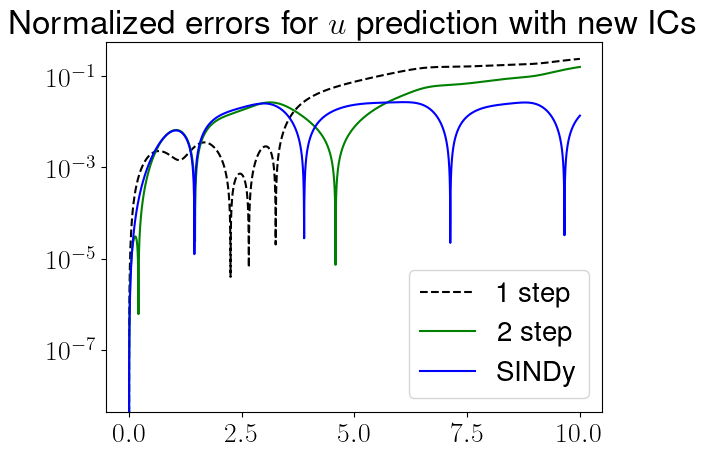

In [92]:
# u errors
# plt.figure(figsize=(15,5))
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
# 1 step method
pred_1_step = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_1_step- true)/jnp.linalg.norm(true),label = '1 step',c = 'black',ls ='dashed')
# 2 step method
pred_2_step = jax.vmap(ode_init.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_2_step- true)/jnp.linalg.norm(true),label = '2 step', c= 'green')
# SINDy method
pred_SINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_SINDy- true)/jnp.linalg.norm(true),label = 'SINDy', c= 'blue')
# Plot configs
plt.title('Normalized errors for $u$ prediction with new ICs')
plt.yscale('log')
plt.legend()
plt.show()

## Initial condition 3

In [93]:
# New initial condition
y0 = jnp.array([0.,-1.])

In [94]:
# P
term = ODETerm(duffing)
# Phat from 1 step
fitted_term = ODETerm(learned_vf)
# Phat from 2 step
init_term = ODETerm(init_vf)

# Simulate between
t0,t1 = 0,10 

ode_truth = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_fitted = diffeqsolve(
    terms = fitted_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_init = diffeqsolve(
    terms = init_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

In [95]:
# SINDy
feature_operators_SINDy = (eval_k,dt_k,dtt_k)

S = (u_model.evaluate_operators(feature_operators_SINDy,t_grid,u_params_init).reshape(
            len(t_grid), 
            len(feature_operators_SINDy),
            order = 'F'
                ))
# Constant
CONST = jnp.ones(len(S[:,0]))
# First degree
U = S[:,0]
U_t = S[:,1]
# Second degree
UU = jnp.multiply(S[:,0],S[:,0])
UU_t = jnp.multiply(S[:,0],S[:,1])
U_tU_t = jnp.multiply(S[:,1],S[:,1])
# Third degree
UUU = jnp.multiply(S[:,0],UU)
UUU_t = jnp.multiply(UU,S[:,1])
UU_tU_t = jnp.multiply(S[:,0],U_tU_t)
U_tU_tU_t = jnp.multiply(S[:,1],U_tU_t)

# Forcing values feature
F = forcing(t_grid)

# Build dictionary
Theta = jnp.vstack([CONST, 
                    U,U_t, 
                    UU,UU_t,U_tU_t,
                    UUU,UUU_t,UU_tU_t,U_tU_tU_t,
                    F[:,0]]).T
# LHS: Assume it is u_ddot
U_tt = S[:,2]

# Threshold algorithm
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi
   
# Run SINDY
coeffs_SINDy = sparsifyDynamics(Theta,U_tt.reshape(-1,1),lamb = 1e-2, n = 1)
coeffs_SINDy = jnp.array(coeffs_SINDy[:,0])
print(coeffs_SINDy)

# Phat from SINDy
@eqx.filter_jit
def Phat_SINDy(t,x, args):
    return jnp.array([
        x[1], jnp.dot(coeffs_SINDy, 
                      jnp.array([1.,
                          x[0],
                          x[1],
                          x[0]**2,
                          x[0] * x[1],
                          x[1]**2,
                          x[0]**3,
                          x[0]**2 * x[1],
                          x[0] * x[1]**2,
                          x[1]**3,
                          forcing(t)
                          ]))
    ])

SINDy_term = ODETerm(Phat_SINDy)

ode_SINDy = diffeqsolve(
    terms = SINDy_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

[-0.17330005  0.38582517  0.19643389  0.17186581 -0.07816957  0.18951089
 -0.82803903 -0.13843791 -0.79903234 -0.07280214  0.32515595]


In [96]:
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

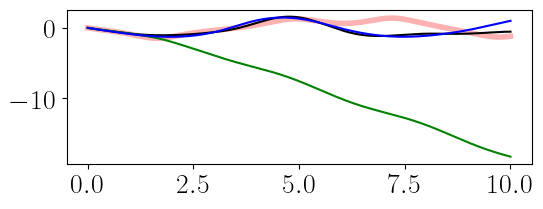

In [97]:
# u predictions
plt.figure(figsize=(6,2))
tvals = jnp.linspace(t0,t1,5000)
# u true
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
plt.plot(tvals, true, label = 'True', c = 'red', lw = 4, alpha= 0.3, zorder=0)
# u pred 1-step
pred1 = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
err_1 = jnp.linalg.norm(true - pred1) / jnp.linalg.norm(true)
plt.plot(tvals,jax.vmap(ode_fitted.evaluate)(tvals)[:,0], c = 'black',ls ='solid',label = r'1-step', zorder=1)
# u pred 2-step
pred2 = jax.vmap(ode_init.evaluate)(tvals)[:,0]
err_2 = jnp.linalg.norm(true - pred2) / jnp.linalg.norm(true)
plt.plot(tvals,pred2,label = r'2-step', c= 'green', zorder=2)
# u pred SINDy
predSINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
err_SINDy = jnp.linalg.norm(true - predSINDy) / jnp.linalg.norm(true)
plt.plot(tvals,predSINDy,label = r'SINDy', c= 'blue', zorder=3)
# Plt configs
# plt.title(f'$u$ predictions of 1 step (err: {round(err_1,3)}), 2 step (err: {round(err_2,3)}) and SINDy (err: {round(err_SINDy,2)}) methods with new ICs')
# plt.xlabel('$t$')
# plt.ylabel('$u$')
# plt.tight_layout()
# plt.legend(fontsize = 11, loc = 'upper center', ncol =4, bbox_to_anchor=(0.5, 1.3))
plt.savefig('u_extrapolating3.pdf',
            dpi=300,
            bbox_inches='tight', 
            format ="pdf"
            )
plt.show()

In [98]:
# Dictionary to store results
errors_IC3 = {'1-step': [],
 '2-step':[],
 'SINDy':[]}


for final in [3,6,10]:
    # Operator learning errors
    tvals = jnp.linspace(t0,final,5000)
    # u true
    true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]

    # u pred 1-step
    pred1 = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
    err_1 = get_nrmse(true,pred1)
    errors_IC3['1-step'].append(float(err_1))
    print(f'Error 1_step in [0,{final}]: ',err_1)

    # u pred 2-step
    pred2 = jax.vmap(ode_init.evaluate)(tvals)[:,0]
    err_2 = get_nrmse(true,pred2)
    errors_IC3['2-step'].append(float(err_2))
    print(f'Error 2_step in [0,{final}]: ',err_2)

    # u pred SINDy
    predSINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
    err_SINDy = get_nrmse(true,predSINDy)
    errors_IC3['SINDy'].append(float(err_SINDy))
    print(f'Error SINDy in [0,{final}]: ',err_SINDy)

Error 1_step in [0,3]:  0.23483772752278045
Error 2_step in [0,3]:  1.4766236181548664
Error SINDy in [0,3]:  0.22769103207783606
Error 1_step in [0,6]:  0.33105099528389265
Error 2_step in [0,6]:  6.324588673298514
Error SINDy in [0,6]:  0.3563366035162108
Error 1_step in [0,10]:  1.0861801202940444
Error 2_step in [0,10]:  11.166609378364281
Error SINDy in [0,10]:  1.2298207925708389


- Accumulated error plot up to time $t$

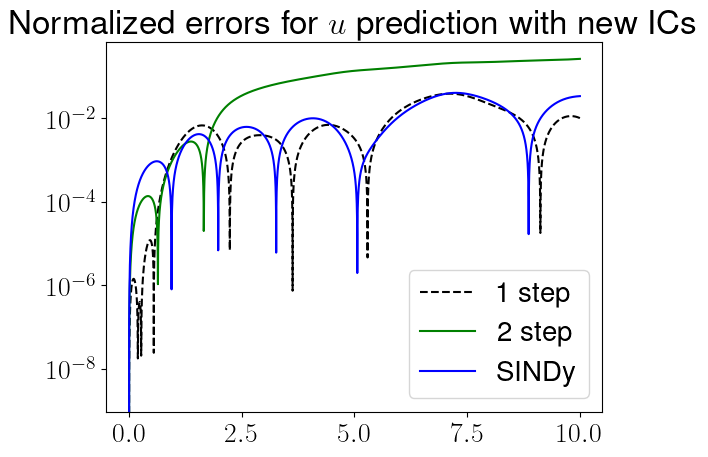

In [99]:
# u errors
# plt.figure(figsize=(15,5))
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
# 1 step method
pred_1_step = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_1_step- true)/jnp.linalg.norm(true),label = '1 step',c = 'black',ls ='dashed')
# 2 step method
pred_2_step = jax.vmap(ode_init.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_2_step- true)/jnp.linalg.norm(true),label = '2 step', c= 'green')
# SINDy method
pred_SINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_SINDy- true)/jnp.linalg.norm(true),label = 'SINDy', c= 'blue')
# Plot configs
plt.title('Normalized errors for $u$ prediction with new ICs')
plt.yscale('log')
plt.legend()
plt.show()

In [100]:
errors_IC1

{'1-step': [0.4880989926151071, 2.359192834544107, 7.233946034622456],
 '2-step': [0.4029572532964768, 1.1033120624521662, 1.6064644769063694],
 'SINDy': [0.6012516658036479, 1.0878453306385194, 1.260313073309397]}

In [101]:
errors_IC2

{'1-step': [0.13532707602043714, 3.656144316253373, 8.363324997560015],
 '2-step': [0.8139804670298139, 1.1672450949206437, 4.144061426651607],
 'SINDy': [0.887114364373077, 1.2984076666629145, 1.2644988353405358]}

In [102]:
errors_IC3

{'1-step': [0.23483772752278045, 0.33105099528389265, 1.0861801202940444],
 '2-step': [1.4766236181548664, 6.324588673298514, 11.166609378364281],
 'SINDy': [0.22769103207783606, 0.3563366035162108, 1.2298207925708389]}

In [103]:
def get_mean(method,idx):
    get_sum = errors_IC1[method][idx]+errors_IC2[method][idx]+errors_IC3[method][idx]
    return get_sum/3

In [104]:
for method in ['1-step','2-step','SINDy']:
    for idx in [0,1,2]:
        if idx == 0:
            print('Average err', method, ' in [0,3]: ', get_mean(method,idx))
        if idx == 1:
            print('Average err', method, ' in [0,6]: ', get_mean(method,idx))
        if idx == 2:
            print('Average err', method, ' in [0,10]: ', get_mean(method,idx))

Average err 1-step  in [0,3]:  0.2860879320527749
Average err 1-step  in [0,6]:  2.1154627153604575
Average err 1-step  in [0,10]:  5.5611503841588386
Average err 2-step  in [0,3]:  0.897853779493719
Average err 2-step  in [0,6]:  2.865048610223775
Average err 2-step  in [0,10]:  5.639045093974086
Average err SINDy  in [0,3]:  0.5720190207515202
Average err SINDy  in [0,6]:  0.9141965336058817
Average err SINDy  in [0,10]:  1.2515442337402571
